In [41]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib2tikz import save as tikz_save
import subprocess
from scipy.optimize import minimize_scalar
from scipy import stats

# Price bounds induced by different methods

In [103]:
N = int(1e5)
X = np.arange(0, 1, .01)
Y = np.zeros(shape=(len(X), 2))
W = np.random.normal(size=(2, N))

bar = lambda k,x: np.sqrt(k**2 - x**2)

_p = .9
_r = .5
_qS = -.005
_qV = -.01
_sV = .2
_sS = .15
_Sh= 2*_qS/_sS
_k = 1

In [101]:
_Sh

-0.06666666666666667

C:\Users\sebastiaanv\AppData\Local\Continuum\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


(0.19611613513818402, -0.19611613052016502)

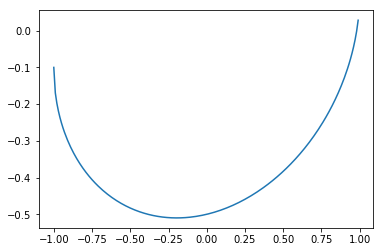

In [318]:
s = lambda x: a*x+-b*bar(1,x)#a*b+a*bar(1,x)+b*x+x*bar(1,x)
a, b = .1, .5
x = np.arange(-1,1,.01)
plt.plot(x, s(x))
a/np.sqrt(a**2+b**2), minimize_scalar(lambda x:s(x)).x

In [104]:
def simulate(Sh=_Sh, qS=_qS, qV=_qV, sS=_sS, sV=_sV, r=_r, k=_k):
    gamma_lb = - np.sqrt(Sh**2 - (qS/sS)**2)
    gamma_ub = + np.sqrt(Sh**2 - (qS/sS)**2)
    
    sigmaM_lb = np.array([qS/sS, gamma_lb])
    muM_lb = -.5 * sigmaM_lb @ sigmaM_lb.T

    sigmaM_ub = np.array([qS/sS, gamma_ub])
    muM_ub = -.5 * sigmaM_ub @ sigmaM_ub.T

    sigmaM = np.array([qS/sS, 0])
    muM = -.5 * sigmaM @ sigmaM.T

    sigmaV = np.array([sV*r, sV*bar(1,r)])
    muV = -qV -.5 * sigmaV @ sigmaV.T
    
    V = np.exp(muV + sigmaV @ W)
    M_lb = np.exp(muM_lb + sigmaM_lb @ W)
    M = np.exp(muM + sigmaM @ W)
    M_ub = np.exp(muM_ub + sigmaM_ub @ W)
    F = np.maximum(0, V-k)
    return V, M_lb, M, M_ub, F

### varying the correlation

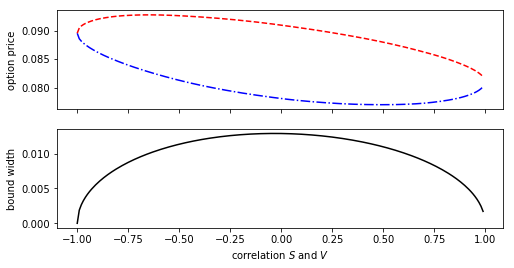

In [116]:
X = np.arange(-1, 1.0, .01)
YF = np.zeros((len(X), 2))
YV = np.zeros((len(X), 2))

for r, YFi, YVi in zip(X, YF, YV):
    V, M_lb, M, M_ub, F = simulate(r=r, Sh=_Sh, k=1)
    YFi += np.array([np.mean(M_lb*F), np.mean(M_ub*F)])
    YVi += np.array([np.mean(M_lb*V), np.mean(M_ub*V)])

fix, (ax1, ax3) = plt.subplots(nrows=2, figsize=(8,4), sharex=True)
ax1.plot(X, YF.T[0], 'b-.', X, YF.T[1], 'r--')
ax3.plot(X, YF[:,1] - YF[:,0], 'k');
ax1.set_ylabel('option price')
ax3.set_ylabel('bound width')
ax3.set_xlabel('correlation $S$ and $V$')

# tikz_save('../scriptie/img/varycorrelation.tex', figureheight='1.5in', figurewidth='4in')
# print(subprocess.check_output(r'cd ..\scriptie\ && git commit -a -m "img" && git pull && git push', shell=True).decode('utf-8'))

In [124]:
1/77, _Sh/5, np.sqrt(_Sh**2 - (_qS/_sS)**2)*_sV

(0.012987012987012988, -0.013333333333333332, 0.011547005383792516)

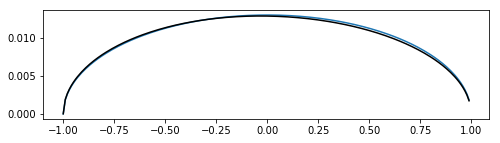

In [129]:
fig, ax = plt.subplots(figsize=(8,2))
ax.plot(X, np.sqrt(1-np.power(X,2))*.013)
ax.plot(X, YF[:,1] - YF[:,0], 'k');

### Varying the unobserved return process

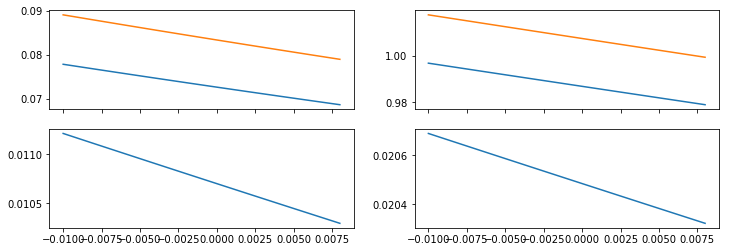

In [232]:
X = np.arange(_qS, -_qS, .001)*2
YF = np.zeros((len(X), 2))
YV = np.zeros((len(X), 2))

for qV, YFi, YVi in zip(X, YF, YV):
    V, M_lb, M, M_ub, F = simulate(qV=qV)
    YFi += np.array([np.mean(M_lb*F), np.mean(M_ub*F)])
    YVi += np.array([np.mean(M_lb*V), np.mean(M_ub*V)])

fix, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,4), sharex=True)
ax1.plot(X, YF)
ax2.plot(X, YV)
ax3.plot(X, YF[:,1] - YF[:,0]);
ax4.plot(X, YV[:,1] - YV[:,0]);

### Varying the strike

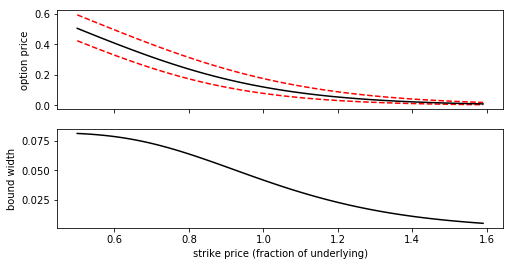

In [141]:
X = np.arange(.5,1.6,.01)
YF = np.zeros((len(X), 3))

for k, YFi in zip(X, YF):
    V, M_lb, M, M_ub, F = simulate(k=k, Sh=5*_Sh, sV=.3)
    YFi += np.array([np.mean(M_lb*F), np.mean(M*F), np.mean(M_ub*F)])

fix, (ax1, ax3) = plt.subplots(nrows=2, figsize=(8,4), sharex=True)
ax1.plot(X, YF.T[0], 'r--', X, YF.T[1], 'k-', X, YF.T[2], 'r--', )
ax3.plot(X, YF[:,1] - YF[:,0], 'k');
ax3.set_xlabel('strike price (fraction of underlying)')
ax1.set_ylabel('option price')
ax3.set_ylabel('bound width')

# ax3.plot(X, stats.norm.cdf(5*(1-X))*.081)
# ax3.plot(X, stats.lognorm.sf(X, s=.3)*.082, 'r-.')

# tikz_save('../scriptie/img/varystrike.tex', figureheight='1.5in', figurewidth='4in')
# print(subprocess.check_output(r'cd ..\scriptie\ && git commit -a -m "img" && git pull && git push', shell=True).decode('utf-8'))

### Varying the unobserved volatility process

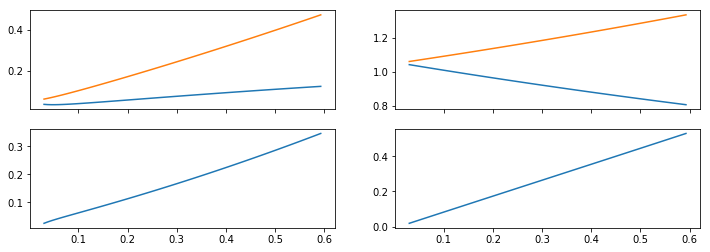

In [57]:
X = np.arange(.2*_sS, 4*_sS, _sS/20)
YF = np.zeros((len(X), 2))
YV = np.zeros((len(X), 2))

for sV, YFi, YVi in zip(X, YF, YV):
    V, M_lb, M, M_ub, F = simulate(sV=sV)
    YFi += np.array([np.mean(M_lb*F), np.mean(M_ub*F)])
    YVi += np.array([np.mean(M_lb*V), np.mean(M_ub*V)])

fix, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,4), sharex=True)
ax1.plot(X, YF)
ax2.plot(X, YV)
ax3.plot(X, YF[:,1] - YF[:,0]);
ax4.plot(X, YV[:,1] - YV[:,0]);


### Varying the sharpe ratio limit

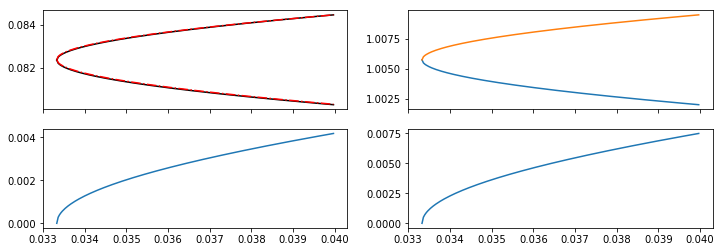

In [183]:
X = -_qS/_sS*np.arange(1, 1.2, .001)
YF = np.zeros((len(X), 2))
YV = np.zeros((len(X), 2))

for Sh, YFi, YVi in zip(X, YF, YV):
    V, M_lb, M, M_ub, F = simulate(Sh=Sh)
    
    YFi += np.array([np.mean(M_lb*F), np.mean(M_ub*F)])
    YVi += np.array([np.mean(M_lb*V), np.mean(M_ub*V)])

fix, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,4), sharex=True)
ax1.plot(X, YF, 'k')
ax2.plot(X, YV)
ax3.plot(X, YF[:,1] - YF[:,0]);
ax4.plot(X, YV[:,1] - YV[:,0]);

a,b,c = -_qS/_sS,.00315,.08238
# X = np.arange(0,2,.01)
ax1.plot(X, c+b/a*np.sqrt(np.power(X,2)-np.power(a,2)), 'r-.', X, c-b/a*np.sqrt(np.power(X,2)-np.power(a,2)), 'r-.')

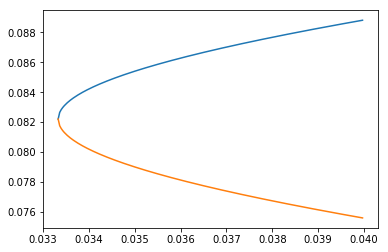

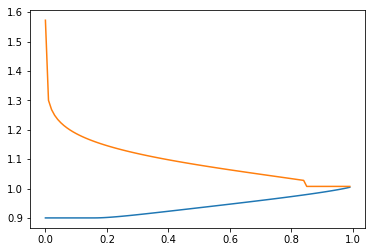

In [223]:
for p, yi in zip(X, Y):
    x = np.maximum(k, np.exp(mux + sigmax @ W))
    #percentile bounds
    yi += np.mean(x[x <= np.percentile(x, 100*p)]), np.mean(x[-x <= np.percentile(-x, 100*p)])

plt.plot(X,Y)

In [155]:
w = np.random.normal(size=(int(1e7),))
mx, sx = 1,.02 
sm = .6
mm = 0
p = .1
x = np.exp(mx + sx*w)
m = np.exp(mm + sm*w)
# ESl = np.mean(x[x <= np.percentile(x, 100*p)])
ESu = np.mean(x[-x <= np.percentile(-x, 100*p)])
ESm = np.mean((x*m)[-x*m <= np.percentile(-x*m, 100*p)])
smb = np.sqrt((np.log(ESu)-mx)*2)-sx
print(f'''{ESl:9.5f}
{ESu:9.5f}
{ESm:9.5f}
{np.mean(m*x):9.5f}

{np.exp(mm+mx+(sm+sx)**2/2):9.5f}
{-np.percentile(-x, 100*p):9.5f}
{smb:9.5f}
''')

  2.62458
  2.81546
  8.37029
  3.29338

  3.29432
  2.78880
  0.24505



In [177]:
import progressbar
bar = progressbar.ProgressBar()

w = np.random.normal(size=(int(1e5),))

X = np.arange(.1, 5,.1)
Y = np.zeros((len(X), 4))
mx, sx = 0,.02 
p = .001

for i, sx in enumerate(X):
    x = np.exp(mx + sx*w)
    ESx = np.mean(x[-x <= np.percentile(-x, 100*p)])
    f = np.maximum(x - np.exp(mx + sx**2/2), 0)
    ESf = np.mean(f[-f <= np.percentile(-f, 100*p)])
    Y[i] = ESx, ESf, np.sqrt((np.log(ESx)-mx)*2)-sx, 0


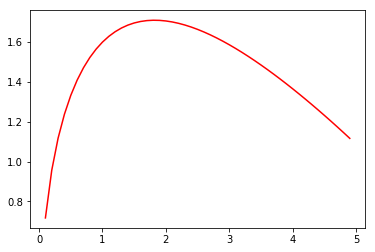

In [178]:
plt.plot(X,Y[:,2], 'r')

# plt.plot(X, np.power(X,1/3), 'k')

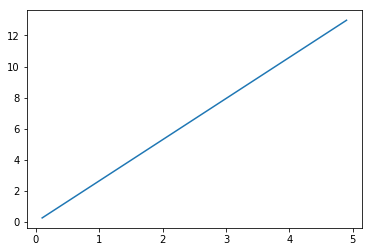

In [25]:

w = np.random.normal(size=(int(1e5),))

X = np.arange(.1, 5,.1)
Y = np.zeros((len(X), ))
mx, sx = 0,.02 
p = .01

for i, sx in enumerate(X):
    x = sx*w
    Y[i] = np.mean(x[-x <= np.percentile(-x, 100*p)])
    
plt.plot(X,Y)

In [20]:
x = np.random.normal(0, 1, size=int(1e6))
es = lambda x: np.mean(x[x < np.percentile(x, 5)])
es(-x), -es(x)

(-2.0670078887025833, 2.0663440657941887)